# CDAW CME Catalog Analysis Notebook
This notebook is for analyzing current CDAW CME catalog to look for differences in CMEs.

Want to understand estimated durations of CME events and build a histogram of this 
data.

In [1]:
import requests
import pandas as pd

Need_To_Redownload = True
CDAW_Catalog_Filename = '../cdaw_catalog.txt'
LASCO_Catalog_Filename = '../lasco_img_catalog.txt'
CME_Catalog_Filename = '../cme_event_catlog.txt'

In [2]:
# pull the cme catalog to local disk
if Need_To_Redownload:
    
    cme_catalog_url = 'https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt'
    response = requests.get(cme_catalog_url, allow_redirects=True)
    
    # cache locally
    open(CDAW_Catalog_Filename, 'wb').write(response.content)

    # parse out data into string lines from byte block
    cdaw_raw_lines = response.content.decode('utf-8').split('\n')
    
    # download LASCO catalog now
    lasco_hdr_url = 'https://lasco-www.nrl.navy.mil/lz/img_hdr.txt'
    response = requests.get(lasco_hdr_url, allow_redirects=True)
    
    # cache locally
    open(LASCO_Catalog_Filename, 'wb').write(response.content)

else:
    
    with open(CDAW_Catalog_Filename, 'r') as f:
        cdaw_raw_lines = f.readlines()
        
    print(f"Read %s CDAW lines" % len(cdaw_raw_lines))
        

In [3]:
#snag field names from top of file. Its not entirely correct, 
# but 'good enough' for now
fields = cdaw_raw_lines[1].split()
fields

['Date',
 'Time',
 'Central',
 'Width',
 'Linear',
 '2nd',
 'order',
 'speed',
 'Accel',
 'Mass',
 'Kinetic',
 'MPA',
 'Remarks']

In [4]:
# parse remainder of lines into dataframe using regex pattern
# only date and time fields appear to be consistently same format,
# we have to guard against non-numbers in all of the other columns
import re

pattern_str = r"^(\d{4}/\d{2}/\d{2})\s+(\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+)\s+(\S+)\s+" +\
              r"(\S+)\s+(\S+)\s+(\S+)\s+(\S+?)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S[\S|\s]+)?$"
pattern = re.compile(pattern_str)

data_arr = { fld:[] for fld in fields }
# parse remainder into columns
for line in cdaw_raw_lines[4:]:
    m = pattern.match(line)
    if m:
        for grp in range(1,len(m.groups())+1): 
            #print(f"{grp}: %s" % m.group(grp))
            data_arr[fields[grp-1]].append(m.group(grp))
    else:
        print (f"Warning: cannot parse line:\n  {line}")
        
raw_data = pd.DataFrame(data_arr)
raw_data

  2001/10/06  18:06:05    100    104    296     275    318    319      1.1    4.3e+15    1.9e+30     74   ]
  2014/11/23  16:12:05     94     57    601     548    661    647      5.0    1.3e+15    2.3e+30     96   \
  2016/12/30  02:24:05    232     25    333     321    346    354      1.0    9.8e+14    5.5e+29    231   n
  


,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3
3,1996/01/22,03:11:01,105,37,267,401,130,0,-126.3*,7.1e+13*,2.5e+28*,103,Very Poor Event; Only C3
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2
30315,2020/05/29,17:36:05,76,34,210,295,120,0,-19.3*,-------,-------,73,Poor Event; Only C2
30316,2020/05/30,01:25:43,80,39,269,203,339,331,2.8,-------,-------,86,None


In [5]:
# filter out data, accelerations with "*" or "------"
# are either unreliable (too few measurements) or no measurement could be made

#filtered = raw_data[raw_data['Accel']!='------']
#filtered = filtered[filtered.Accel.str.contains('\*') == False]
#filtered

In [6]:
# Data Cleaning: filter out Bad/Poor data: Missing Linear speed ('------') and
# 'Very Poor Event' and 'None' in Remarks
# 
cleaned = raw_data[raw_data['Linear'] != '----']
cleaned = cleaned[cleaned.Remarks.str.contains('Very Poor Event') == False]
cleaned = cleaned[cleaned.Remarks.str.contains('None') == False]
cleaned

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,3.2e+28*,272,Poor Event; Only 3 points
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,2020/05/28,21:12:11,260,23,187,183,192,214,0.5*,-------,-------,258,Poor Event
30312,2020/05/29,08:00:05,79,37,337,373,301,0,-13.2*,-------,-------,69,Poor Event; Only C2
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2


## calculate durations for each detector (C2 1.5 - 6 Rsol and C3 is 3.7 - 30 Rsol)

#### T_c2_start == catalog time_start

Our formula for duration:
  700,000 * Det_max_Rsol /linear speed = T_duration_det

#### C2 Duration : 4200000 / speed = T_c2
 
C3 Start time delta (from C2) is C2_Start + (3.7 - 1.5) * R_sol
or
2.2 * R_sol  = T_c3_start_delta

#### C3 Delta Start is 1540000 + T_c2_start

C3 duration is (30 - 3.7) * R_sol / linear speed

#### C3 Duration: 18410000 / speed = T_c3




In [7]:
c2_durations = [ 4200000./int(speed) for speed in cleaned['Linear']]
c3_durations = [ 18410000./int(speed) for speed in cleaned['Linear']]
# delta is C3 start time (est) after event start (at Sun).
c3_start_delta = [1540000./int(speed) for speed in cleaned['Linear']]

In [8]:
data = cleaned
data['Duration_C2'] = c2_durations
data['Duration_C3'] = c3_durations
data['StartTime_C3_Delta'] = c3_start_delta

In [9]:
data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta
0,1996/01/11,00:14:36,267,18,499,571,426,0,-64.3*,-------,-------,272,Only C3,8416.833667,36893.787575,3086.172345
1,1996/01/13,22:08:30,265,16,290,278,303,372,2.8*,-------,-------,266,Only C3,14482.758621,63482.758621,5310.344828
2,1996/01/15,07:01:10,262,43,525,600,454,0,-31.1,-------,-------,272,Only C3,8000.000000,35066.666667,2933.333333
4,1996/01/26,09:16:19,90,27,262,254,271,322,1.9*,3.0e+14,1.0e+29,90,Poor Event; Only C3,16030.534351,70267.175573,5877.862595
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,3.2e+28*,272,Poor Event; Only 3 points,26582.278481,116518.987342,9746.835443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,2020/05/28,21:12:11,260,23,187,183,192,214,0.5*,-------,-------,258,Poor Event,22459.893048,98449.197861,8235.294118
30312,2020/05/29,08:00:05,79,37,337,373,301,0,-13.2*,-------,-------,69,Poor Event; Only C2,12462.908012,54629.080119,4569.732938
30313,2020/05/29,11:24:05,84,52,347,406,288,0,-21.9*,-------,-------,68,Poor Event; Only C2,12103.746398,53054.755043,4438.040346
30314,2020/05/29,15:12:05,83,46,204,215,193,0,-2.8*,-------,-------,74,Poor Event; Only C2,20588.235294,90245.098039,7549.019608


In [10]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot_data (xdata, ydata, xlabel="", ylabel=""):

    fig, ax = plt.subplots()
    #plt.style.use('fivethirtyeight')
    
    ax.plot(xdata, ydata, 'ro')
    ax.set_title("Foobar")
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    
def plot_hist(data, what, nbins:int=100, ylog:bool=False, xlow:int=0, xhigh:int=None, nofill:bool=False):
    
    fig, ax = plt.subplots()
        
    if nofill:
        data.hist(ax=ax, bins=nbins, bottom=0, fill=None)
    else:
        data.hist(ax=ax, bins=nbins, bottom=0)
    ax.set_title("Histogram")
    ax.set(xlabel=what, ylabel="Num/bin")
    
    if xlow != None and xhigh != None:
        plt.xlim(xlow, xhigh)
        
    #plt.xticks(rotation=90)
    
    #plt.style.use('fivethirtyeight')
    if ylog:
        ax.set_yscale('log')
        #ax.set_xscale('log')

In [11]:
# Split into detector specific datasets
c2_data = data[data.Remarks.str.contains('Only C2')]
c3_data = data[data.Remarks.str.contains('Only C3')]
c2_c3_data = data[data.Remarks.str.contains('Only C2') == False]
c2_c3_data = c2_c3_data[c2_c3_data.Remarks.str.contains('Only C3') == False]
len(c2_data), len(c3_data), len(c2_c3_data)

(4723, 295, 7575)

In plots below we compare different durations to see if they indicate 
different underlying populations of CME being detected. A comparison of the peaks 
shows that they are basically the same underlying population and we may combine
different C2, C3 classifiers later on to detect CME. 

X-axis scale is the same for easier comparison. C3 data statistics are too poor.

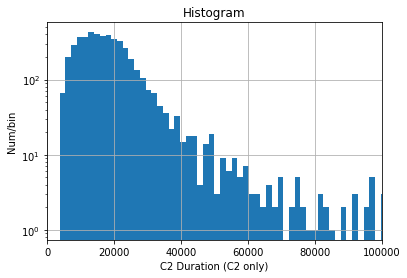

In [12]:
plot_hist(c2_data['Duration_C2'], what='C2 Duration (C2 only)', ylog=True, xhigh=100000)

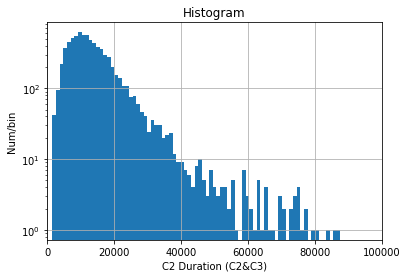

In [13]:
plot_hist(c2_c3_data['Duration_C2'], what='C2 Duration (C2&C3)', ylog=True, xhigh=100000)

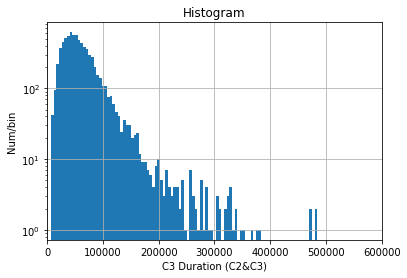

In [14]:
plot_hist(c2_c3_data['Duration_C3'], what='C3 Duration (C2&C3)', ylog=True, xhigh=600000)

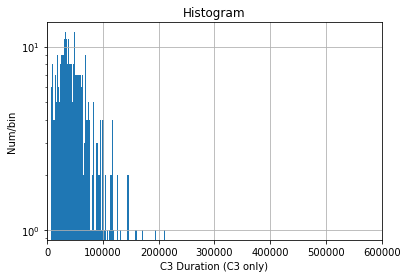

In [15]:
plot_hist(c3_data['Duration_C3'], what='C3 Duration (C3 only)', ylog=True, xhigh=600000)

In [16]:
c2_c3_data

,Date,Time,Central,Width,Linear,2nd,order,speed,Accel,Mass,Kinetic,MPA,Remarks,Duration_C2,Duration_C3,StartTime_C3_Delta
5,1996/01/31,06:52:13,274,47,158,219,99,0,-12.3*,2.5e+14*,3.2e+28*,272,Poor Event; Only 3 points,26582.278481,116518.987342,9746.835443
8,1996/02/12,05:47:26,91,53,160,100,211,236,2.0*,1.3e+15,1.6e+29,92,Poor Event,26250.000000,115062.500000,9625.000000
12,1996/03/02,04:11:53,88,36,108,95,120,177,1.0*,1.5e+14,8.7e+27,86,Poor Event,38888.888889,170462.962963,14259.259259
16,1996/03/07,07:51:56,91,43,60,60,61,75,0.1*,-------,-------,87,Poor Event,70000.000000,306833.333333,25666.666667
18,1996/03/09,04:27:49,84,39,93,102,82,0,-1.1*,-------,-------,82,Only 3 points,45161.290323,197956.989247,16559.139785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30300,2020/05/26,00:36:06,255,95,142,75,216,289,3.2*,-------,-------,251,Poor Event,29577.464789,129647.887324,10845.070423
30301,2020/05/26,10:36:05,242,36,172,159,185,271,2.0*,-------,-------,262,Poor Event,24418.604651,107034.883721,8953.488372
30303,2020/05/27,06:00:06,83,17,108,89,129,222,1.8*,-------,-------,89,Poor Event,38888.888889,170462.962963,14259.259259
30309,2020/05/28,03:12:09,87,19,173,132,217,406,6.6*,-------,-------,87,Poor Event,24277.456647,106416.184971,8901.734104


In [17]:
c2_c3_data.to_csv(CME_Catalog_Filename)